## RECEPTI, *Projektna naloga pri predemtu Programiranje 1*
#### Marija Jezeršek

### Uvod:

V tej projektni nalogi analiziram recepte s strani "Kulinarika.net". S strani sem zajela podatke 12766 receptov iz kategorij juhe, solate, priloge, mesne jedi, zelenjavne jedi in sladice. Vsak recept ima podatke o imenu recepta in avtorja, času priprave, povprečni oceni, kategoriji, sestavinah in postopku priprave. Poleg tega ima vsak recept tudi svoj indeks, ki povezuje osnovne podatke recepta s podatki o sestavinah in postopku, ki so shranjeni v različnih CSV-datotekah.

Delovne hipoteze, ki sem si jih zastavila in so obravnavane v projektu, so:
- Kakšna je povezava med zahtevnostjo priprave in dolžino navodil, časom priprave ter številom različnih sestavin?
- Jedi s katereimi sestavinami imajo najboljše ocene?
- Z uporabo naivnega Bayesovega klasifikatorja poskusim iz sestavin napovedati kategorijo jedi.

In [1]:
# naložimo paket
import pandas as pd
import re
from tqdm import tqdm
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# ker bomo delali z velikimi razpredelnicami, povemo, da naj se vedno izpiše le 10 vrstic
pd.set_option('display.max_rows', 10)

Ker nam tudi Kulinarika poda svojo oceno zahtevnosti (sklepam, da gre za (subjektivno) oceno avtorja recepta), bom s shranjenih html strani najprej pridobila še podatke o tem, da jih bom kasneje lahko primerjala s svojo oceno.

In [242]:
recepti = pd.read_csv('podatki_z_indeksi.csv')

recepti['predvidena_tezavnost'] = 0
predvidena_tezavnost = recepti['predvidena_tezavnost']

for vrstica in tqdm(recepti.iloc, total=len(recepti)):
    pot = f"html_strani/{vrstica['indeks']}.html"

    with open(pot, 'r', encoding='utf-8') as d:
        vsebina = d.read()
    vzorec_zahtevnost = re.compile(r"""<img src='/grafika6/ikona-utez.png'""", re.DOTALL)
    z = re.findall(vzorec_zahtevnost, vsebina)

    predvidena_tezavnost[recepti['indeks'] == vrstica['indeks']] = len(z)


recepti.to_csv('podatki_z_indeksi.csv')

  0%|          | 0/12766 [00:00<?, ?it/s]C:\Users\Marija\AppData\Local\Temp\ipykernel_12740\3744588564.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predvidena_tezavnost[recepti['indeks'] == vrstica['indeks']] = len(z)
100%|██████████| 12766/12766 [00:38<00:00, 330.35it/s]


### Indeks zahtevnosti priprave:

Po moji oceni je zahtevnost priprave odvisna od časa priprave $ t $, dolžine opisa postopka priprave $ l $ in številom različnih sestavin $ n $, ki jih potrebuješ za pripravo jedi. Na podlagi teh parametrov bom za vsak recept izračunala indeks zahtevnosti priprave recepta $ z $ po formuli:
$$ z =  t l \log n  $$

In [2]:
def cas_v_minutah(niz):
    """ Pretvori čas priprave v celo število minut, potrebnih za priprvo. """
    if "ur" in niz and "min" in niz:
        return str(int(re.findall(r"\d+", niz)[0]) * 60 + int(re.findall(r"\d+", niz)[1]))
    elif niz[-3:] == 'min':
        return str(niz.split(' ')[0])
    elif niz[-3:] in {'ura', ' ur', 'ure', "uri"}:
        return str(int(re.findall(r"\d+", niz)[0]) * 60)
    else:
        return None

def povp(df):
    return (df - df.mean()) / df.std()

def minmax(df):
    return (df - df.min()) / (df.max() - df.min())

C:\Users\Marija\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\lib\histograms.py:837: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Marija\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\lib\histograms.py:838: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


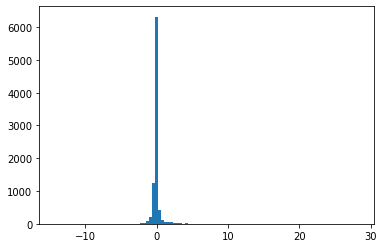

In [53]:
recepti = pd.read_csv('podatki_z_indeksi.csv')
sestavine = pd.read_csv('sestavine.csv')
postopki = pd.read_csv('postopki.csv')


recepti['čas_priprave_min'] = recepti['čas_priprave'].apply(cas_v_minutah)
maska = ~recepti["čas_priprave_min"].isnull()
t = pd.to_numeric(recepti["čas_priprave_min"])[maska]


t_norm = povp(t)

postopki['dolzina'] = postopki.postopek.str.split(" ").str.len()
l = postopki.groupby("indeks").sum("dolzina").dolzina[maska]
l_ = l

l_norm = povp(l_)

n = sestavine.groupby("indeks").size()[maska]
n_ = np.log(n)

n_norm = povp(n_)

zahtevnost = recepti['čas_priprave_min'].copy()
zahtevnost[maska] =  (t_norm * l_norm * n_norm)
recepti["zahtevnost"] = povp(zahtevnost)

_ = plt.hist(recepti["zahtevnost"], bins=100)

# a = recepti.groupby("zahtevnost").size()
# a.plot()

Zdaj smo dobili porazdelitev receptov glede na njihovo zahtevnost, izračunano po naši formuli in standardno porazdeljene. Sedaj bomo odstranili 20 največjih in najmanjših, jim dali oceno 5 oz. 0, ostale pa normirali od 0 do 5.

lower: -1.8636943557439394, upper: 3.0709304681578353
0 5


C:\Users\Marija\AppData\Local\Temp\ipykernel_9848\775650510.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recepti["zahtevnost"][maska_na] = zahtevnost_brez_na


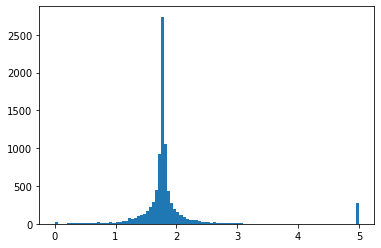

In [56]:
maska_na = ~recepti['zahtevnost'].isna()
zahtevnost_brez_na = recepti['zahtevnost'][maska_na]
sez = zahtevnost_brez_na.copy().to_numpy()
sez.sort()
lower, upper = sez[20], sez[-100]

print(f"lower: {lower}, upper: {upper}")

maska = (zahtevnost_brez_na < upper) & (zahtevnost_brez_na > lower)

zahtevnost_brez_na[maska] = 5 * minmax(zahtevnost_brez_na[maska])
zahtevnost_brez_na[zahtevnost_brez_na >= upper] = 5
zahtevnost_brez_na[zahtevnost_brez_na <= lower] = 0
print(zahtevnost_brez_na.min(), zahtevnost_brez_na.max())

_ = plt.hist(zahtevnost_brez_na.to_numpy(), bins=100)



recepti["zahtevnost"][maska_na] = zahtevnost_brez_na

# a = recepti.groupby("zahtevnost").size()
# a.plot()

In [57]:
recepti

,Unnamed: 0,indeks,povezava,ime,avtor,čas_priprave,povprečna_ocena,kategorija,predvidena_tezavnost,čas_priprave_min,zahtevnost
0,0,0,'/recepti/juhe-in-zakuhe/ostale-juhe/cmocki-sa...,Cmočki šarenke v žametni bučni juhi,Spar Slovenija,45 min,Unknown,juha,2,45,1.833478
1,1,1,'/recepti/juhe-in-zakuhe/ostale-juhe/spargljev...,Špargljeva kremna juha z žličniki iz šunke in ...,HOFER Slovenija,45 min,Unknown,juha,3,45,1.674836
2,2,2,'/recepti/juhe-in-zakuhe/ostale-juhe/skutn-ca/...,Skutn'ca,ZELENE DOLINE,15 min,Unknown,juha,1,15,1.362354
3,3,3,'/recepti/juhe-in-zakuhe/jusne-zakuhe/domaca-r...,Domača ribana kaša,Žito,30 min,Unknown,juha,2,30,1.169352
4,4,4,'/recepti/juhe-in-zakuhe/hladne-juhe/hladna-ku...,Hladna kumarična juha z morskim nabodalom,HOFER Slovenija,30 min,Unknown,juha,2,30,1.784595
...,...,...,...,...,...,...,...,...,...,...,...
12761,12761,12761,'/recepti/sladice/palacinke/palacinke-z-jabolc...,Palačinke z jabolčnim sirupom in ginom,percya,30 min,Unknown,sladice,2,30,1.815629
12762,12762,12762,'/recepti/sladice/palacinke/lesnikove-palacink...,Lešnikove palačinke,Kitchen bee,15 min,Unknown,sladice,1,15,1.736915
12763,12763,12763,'/recepti/sladice/pecivo/pecivo-5-4/22612/',Pecivo 5/4,Miss Pariz,1 ura,Unknown,sladice,1,60,1.748273
12764,12764,12764,'/recepti/sladice/pecivo/cokoladna-tortica-z-r...,Čokoladna tortica z rdečim vinom v skodelici,Neza V.,30 min,Unknown,sladice,2,30,1.784707


Najprej je treba moje podatke normalizirati do 5, nato pa lahko izračunamo razmerje $z/t$, kjer je $z$ zahtevnost, izračunana po naših postopkih, $t$ pa predvidena težavnost, podana na strani.

In [86]:
recepti["odstopanje_zahtevnosti"] = 1 - recepti["zahtevnost"] / recepti["predvidena_tezavnost"]
recepti

,Unnamed: 0,indeks,povezava,ime,avtor,čas_priprave,povprečna_ocena,kategorija,predvidena_tezavnost,čas_priprave_min,zahtevnost,odstopanje_zahtevnosti
0,0,0,'/recepti/juhe-in-zakuhe/ostale-juhe/cmocki-sa...,Cmočki šarenke v žametni bučni juhi,Spar Slovenija,45 min,Unknown,juha,2,45,-0.040382,1.020191
1,1,1,'/recepti/juhe-in-zakuhe/ostale-juhe/spargljev...,Špargljeva kremna juha z žličniki iz šunke in ...,HOFER Slovenija,45 min,Unknown,juha,3,45,-0.19615,1.065383
2,2,2,'/recepti/juhe-in-zakuhe/ostale-juhe/skutn-ca/...,Skutn'ca,ZELENE DOLINE,15 min,Unknown,juha,1,15,-0.502969,1.502969
3,3,3,'/recepti/juhe-in-zakuhe/jusne-zakuhe/domaca-r...,Domača ribana kaša,Žito,30 min,Unknown,juha,2,30,-0.692474,1.346237
4,4,4,'/recepti/juhe-in-zakuhe/hladne-juhe/hladna-ku...,Hladna kumarična juha z morskim nabodalom,HOFER Slovenija,30 min,Unknown,juha,2,30,-0.08838,1.04419
...,...,...,...,...,...,...,...,...,...,...,...,...
12761,12761,12761,'/recepti/sladice/palacinke/palacinke-z-jabolc...,Palačinke z jabolčnim sirupom in ginom,percya,30 min,Unknown,sladice,2,30,-0.057908,1.028954
12762,12762,12762,'/recepti/sladice/palacinke/lesnikove-palacink...,Lešnikove palačinke,Kitchen bee,15 min,Unknown,sladice,1,15,-0.135196,1.135196
12763,12763,12763,'/recepti/sladice/pecivo/pecivo-5-4/22612/',Pecivo 5/4,Miss Pariz,1 ura,Unknown,sladice,1,60,-0.124044,1.124044
12764,12764,12764,'/recepti/sladice/pecivo/cokoladna-tortica-z-r...,Čokoladna tortica z rdečim vinom v skodelici,Neza V.,30 min,Unknown,sladice,2,30,-0.08827,1.044135


<AxesSubplot: xlabel='odstopanje_zahtevnosti'>

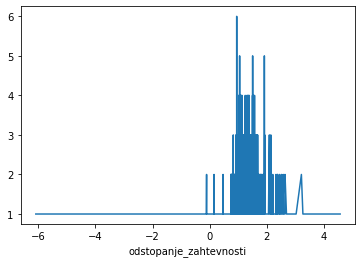

In [87]:
%matplotlib inline

a = recepti.groupby("odstopanje_zahtevnosti").size()
a.plot()

<AxesSubplot: xlabel='zahtevnost'>

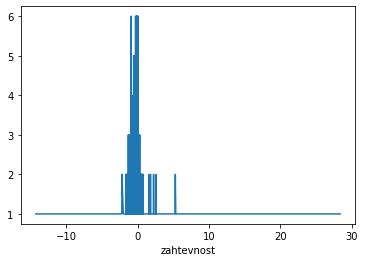

In [88]:
recepti_po_zahtevnosti = recepti.groupby("zahtevnost").size()
recepti_po_zahtevnosti.plot()


Opazimo lahko, da na ta način dobimo ogromna odstopanja med napovedano in izračunano oceno zahtevnosti. Prav tako večina receptov na ta način dobi zelo nizke ocene (praktično nič).

Zato poskusimo oceno težavnosti določiti še na drug način: postavimo kriterij, po katerem od 0 do 5 ocenimo težavnost časa priprave, števila sestavin in dolžine postopka. Nato izračunamo njihovo povprečje, kar postane skupna ocena zahtevnosti.

In [74]:
def casovni_kriterij(cas_v_minutah):
    cas_v_minutah = int(cas_v_minutah)
    if cas_v_minutah >= 69:
        return 5
    else:
        return (0.0971636 * (cas_v_minutah ** 0.944257)) - 0.383887

def sestavine_kriterij(st_sestavin):
    if st_sestavin >= 11:
        return 5
    else:
        return (st_sestavin - 3) / 2 

def postopek_kriterij(dolzina_postopka):
    if dolzina_postopka <= 10:
        return 0
    elif dolzina_postopka >= 435:
        return 5
    else:
        return (0.257975 * (dolzina_postopka ** 0.513715)) - 0.853943


,Unnamed: 0,indeks,povezava,ime,avtor,čas_priprave,povprečna_ocena,kategorija,predvidena_tezavnost,čas_priprave_min,zahtevnost1
0,0,0,'/recepti/juhe-in-zakuhe/ostale-juhe/cmocki-sa...,Cmočki šarenke v žametni bučni juhi,Spar Slovenija,45 min,Unknown,juha,2,45,3.29561
1,1,1,'/recepti/juhe-in-zakuhe/ostale-juhe/spargljev...,Špargljeva kremna juha z žličniki iz šunke in ...,HOFER Slovenija,45 min,Unknown,juha,3,45,3.730507
2,2,2,'/recepti/juhe-in-zakuhe/ostale-juhe/skutn-ca/...,Skutn'ca,ZELENE DOLINE,15 min,Unknown,juha,1,15,1.236495
3,3,3,'/recepti/juhe-in-zakuhe/jusne-zakuhe/domaca-r...,Domača ribana kaša,Žito,30 min,Unknown,juha,2,30,1.071248
4,4,4,'/recepti/juhe-in-zakuhe/hladne-juhe/hladna-ku...,Hladna kumarična juha z morskim nabodalom,HOFER Slovenija,30 min,Unknown,juha,2,30,3.01533
...,...,...,...,...,...,...,...,...,...,...,...
12761,12761,12761,'/recepti/sladice/palacinke/palacinke-z-jabolc...,Palačinke z jabolčnim sirupom in ginom,percya,30 min,Unknown,sladice,2,30,2.606031
12762,12762,12762,'/recepti/sladice/palacinke/lesnikove-palacink...,Lešnikove palačinke,Kitchen bee,15 min,Unknown,sladice,1,15,2.062081
12763,12763,12763,'/recepti/sladice/pecivo/pecivo-5-4/22612/',Pecivo 5/4,Miss Pariz,1 ura,Unknown,sladice,1,60,2.456122
12764,12764,12764,'/recepti/sladice/pecivo/cokoladna-tortica-z-r...,Čokoladna tortica z rdečim vinom v skodelici,Neza V.,30 min,Unknown,sladice,2,30,2.987883


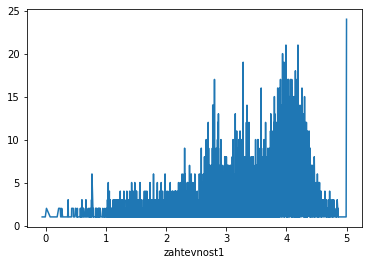

In [79]:
recepti = pd.read_csv('podatki_z_indeksi.csv')
sestavine = pd.read_csv('sestavine.csv')
postopki = pd.read_csv('postopki.csv')


recepti['čas_priprave_min'] = recepti['čas_priprave'].apply(cas_v_minutah)
maska = ~recepti["čas_priprave_min"].isnull()
t = recepti["čas_priprave_min"][maska].apply(casovni_kriterij)

postopki['dolzina'] = postopki.postopek.str.split(" ").str.len()
l = postopki.groupby("indeks").sum("dolzina").dolzina[maska]
l = l.apply(postopek_kriterij)

n = sestavine.groupby("indeks").size()[maska]
n = n.apply(sestavine_kriterij)



zahtevnost = recepti['čas_priprave_min'].copy()
zahtevnost[maska] =  (t + l + n) / 3
recepti["zahtevnost1"] = zahtevnost

a = recepti.groupby("zahtevnost1").size()
a.plot()


<AxesSubplot: xlabel='odstopanje_zahtevnosti1'>

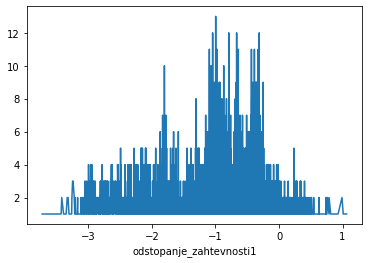

In [82]:
recepti["odstopanje_zahtevnosti1"] = 1 - recepti["zahtevnost1"] / recepti["predvidena_tezavnost"]
a = recepti.groupby("odstopanje_zahtevnosti1").size()
a.plot()
